### Relax data Take Home Challenge

- The data is available as two attached CSV files:
takehome_user_engagement.csv
takehome_users.csv

The data has the following two tables:
1] A user table ("takehome_users") with data on 12,000 users who signed up for the
product in the last two years. This table includes:
● name: the user's name
● object_id: the user's id
● email: email address
● creation_source: how their account was created. This takes on one
of 5 values:
○ PERSONAL_PROJECTS: invited to join another user's
personal workspace
○ GUEST_INVITE: invited to an organization as a guest
(limited permissions)
○ ORG_INVITE: invited to an organization (as a full member)
○ SIGNUP: signed up via the website
○ SIGNUP_GOOGLE_AUTH: signed up using Google
Authentication (using a Google email account for their login
id)
● creation_time: when they created their account
● last_session_creation_time: unix timestamp of last login
● opted_in_to_mailing_list: whether they have opted into receiving
marketing emails
● enabled_for_marketing_drip: whether they are on the regular
marketing email drip
● org_id: the organization (group of users) they belong to
● invited_by_user_id: which user invited them to join (if applicable).


2] A usage summary table ("takehome_user_engagement") that has a row for each day
that a user logged into the product.Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven­day period, identify which factors predict future user
adoption.


We suggest spending 1­2 hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better ­­ no more
than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
%matplotlib inline
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [2]:
ls

 Volume in drive C is Windows 10
 Volume Serial Number is 8CEF-8E27

 Directory of C:\Users\Sanjay\3datascienceprojects\datascienceprojects\Challenges\relax_challenge_springboard\notebooks

20-12-2020  01:10    <DIR>          .
20-12-2020  01:10    <DIR>          ..
16-12-2020  17:47                 0 .gitkeep
17-12-2020  12:33    <DIR>          .ipynb_checkpoints
20-12-2020  01:10            88,072 Relax challenge.ipynb
               2 File(s)         88,072 bytes
               3 Dir(s)  358,050,893,824 bytes free


In [3]:
#read files csv
path ='C:/Users/Sanjay/3datascienceprojects/datascienceprojects/Challenges/relax_challenge_springboard/data/raw'
users_df = pd.read_csv(path+'/takehome_users.csv',encoding='latin-1')#unicode error
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
engagement_df =pd.read_csv(path+'/takehome_user_engagement.csv',encoding='latin-1')
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
print("No of users:",engagement_df['user_id'].nunique())
print("No of logins: ",len(engagement_df))

No of users: 8823
No of logins:  207917


#### Given that : Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption

In [8]:
# convert the timestamp into datetime object
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

In [9]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [10]:
#  first drop duplicate days and sort by day
# # calculate how many days has passed for every 3 logins
# check if any passed time is less than 7 days
def logins_days(df, days=7, logins=3):
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = df['date'].diff(periods=logins-1)
    return any(passed_days <= timedelta(days=days))

In [11]:
adopted = engagement_df.groupby('user_id').apply(logins_days)
adopted.name = 'adopted_user'

In [12]:
adopted

user_id
1        False
2         True
3        False
4        False
5        False
         ...  
11996    False
11997    False
11998    False
11999    False
12000    False
Name: adopted_user, Length: 8823, dtype: bool

In [13]:
print("adopted users: ", sum(adopted), "in total users : ", len(adopted))

adopted users:  1656 in total users :  8823


In [14]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [15]:
# 5 Organizations with most users
users_df['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [16]:
# 5 Users with most invites
users_df['invited_by_user_id'].value_counts().head()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
Name: invited_by_user_id, dtype: int64

In [17]:
# lets create a feature of user history by using creation time and last creation time
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'], format='%Y-%m-%d %H:%M:%S')
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')
# calculate user history, defined as number of days between account creation and last use
users_df['history'] = users_df['last_session_creation_time'] - users_df['creation_time']
users_df['history'] = users_df['history'].dt.days

In [18]:
users_df.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0


In [19]:
users_df.drop('creation_time',axis=1,inplace=True)

In [20]:
users_df.drop('last_session_creation_time',axis=1,inplace=True)

In [21]:
users_df.head()

,object_id,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,0.0
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,1.0
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,5.0


In [22]:
#merging user data ands 'adopted user'
users_df = users_df.set_index('object_id')
users_df.index.name = 'user_id'

In [23]:
data = pd.concat([users_df, adopted], axis=1, join='inner')

In [24]:
data['adopted_user'] = data['adopted_user'].astype(int)

In [25]:
data.head()

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history,adopted_user
user_id,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0,0
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0,1
3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,0.0,0
4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,1.0,0
5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,5.0,0


### Expolaratory Data Analysis  


<AxesSubplot:xlabel='creation_source', ylabel='count'>

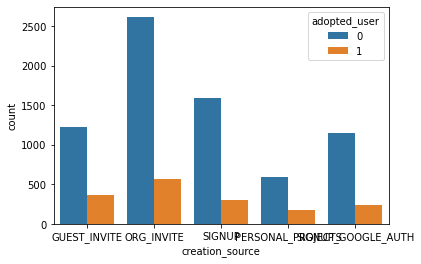

In [26]:
sns.countplot(x = 'creation_source',data = data, hue = 'adopted_user')

In [27]:
data['adopted_user'].value_counts()

0    7167
1    1656
Name: adopted_user, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='adopted_user', ylabel='count'>

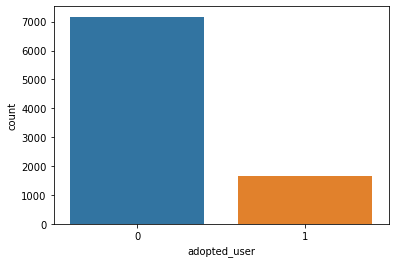

In [28]:
sns.countplot(data['adopted_user'])

### Modeling

In [29]:
data['creation_source'].unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [30]:
creation_source = pd.get_dummies(data['creation_source'],drop_first=True)

In [31]:
data.head()

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history,adopted_user
user_id,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0,0
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0,1
3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,0.0,0
4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,1.0,0
5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,5.0,0


In [32]:
data_users_final = pd.concat([data,creation_source],axis=1)

In [33]:
data_users_final.head()

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history,adopted_user,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0,0,0,0,0,0
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0,1,1,0,0,0
3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,0.0,0,1,0,0,0
4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,1.0,0,0,0,0,0
5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,5.0,0,0,0,0,0


In [34]:
data_users_final.drop('creation_source',axis=1,inplace=True)

In [35]:
 data_users_final.head()

,name,email,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history,adopted_user,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,1,0,11,10803.0,0.0,0,0,0,0,0
2,Poole Matthew,MatthewPoole@gustr.com,0,0,1,316.0,136.0,1,1,0,0,0
3,Bottrill Mitchell,MitchellBottrill@gustr.com,0,0,94,1525.0,0.0,0,1,0,0,0
4,Clausen Nicklas,NicklasSClausen@yahoo.com,0,0,1,5151.0,1.0,0,0,0,0,0
5,Raw Grace,GraceRaw@yahoo.com,0,0,193,5240.0,5.0,0,0,0,0,0


In [36]:
data_users_final.drop(['name','email'],axis=1,inplace=True)

In [37]:
data_users_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   opted_in_to_mailing_list    8823 non-null   int64  
 1   enabled_for_marketing_drip  8823 non-null   int64  
 2   org_id                      8823 non-null   int64  
 3   invited_by_user_id          4776 non-null   float64
 4   history                     8823 non-null   float64
 5   adopted_user                8823 non-null   int32  
 6   ORG_INVITE                  8823 non-null   uint8  
 7   PERSONAL_PROJECTS           8823 non-null   uint8  
 8   SIGNUP                      8823 non-null   uint8  
 9   SIGNUP_GOOGLE_AUTH          8823 non-null   uint8  
dtypes: float64(2), int32(1), int64(3), uint8(4)
memory usage: 802.5 KB


In [38]:
#convert columns to float64
for col in data_users_final.columns:
    data_users_final[col] = data_users_final[col].astype('float64')

In [39]:
data_users_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   opted_in_to_mailing_list    8823 non-null   float64
 1   enabled_for_marketing_drip  8823 non-null   float64
 2   org_id                      8823 non-null   float64
 3   invited_by_user_id          4776 non-null   float64
 4   history                     8823 non-null   float64
 5   adopted_user                8823 non-null   float64
 6   ORG_INVITE                  8823 non-null   float64
 7   PERSONAL_PROJECTS           8823 non-null   float64
 8   SIGNUP                      8823 non-null   float64
 9   SIGNUP_GOOGLE_AUTH          8823 non-null   float64
dtypes: float64(10)
memory usage: 1.1 MB


In [40]:
#fill na values in invited_by_user column
data_users_final['invited_by_user_id'].fillna(value=0,inplace=True)

In [41]:
#lets use the above dataframe now and separate the target and feature variables
y = data_users_final['adopted_user']
X = data_users_final.drop('adopted_user', axis=1)

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size = 0.3, random_state = 42)

In [43]:
#Using RandomForestClassifier to handle imbalance
rand_clf = RandomForestClassifier(random_state = 42)


In [44]:
rand_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [45]:
rand_clf.score(X_test,y_test)

0.9595768794862108

In [46]:
imp = pd.Series(rand_clf.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.871712
org_id                        0.068472
invited_by_user_id            0.039299
opted_in_to_mailing_list      0.005145
ORG_INVITE                    0.004144
enabled_for_marketing_drip    0.003692
SIGNUP                        0.002654
SIGNUP_GOOGLE_AUTH            0.002535
PERSONAL_PROJECTS             0.002348
dtype: float64


#### Here we can see that 
From the above observation "history" is of maximum importance
it is calculatedusing the "last session creation time " and "creation time" has the mximum importance
So we can say that  these are the most predicitve of future adoption of users